## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline. In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

In [97]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string

## Take Input

In [57]:
# read the train and test data
def readInputFiles(train_file_path, test_file_path):
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    return train, test
    
train, test = readInputFiles('../input/train.csv', '../input/test.csv')

## Data Exploration

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Average length of comments: 393
Standard dev: 589
Longest Comment: 5000

# Comments in train data: 159571 
# Comments in test data: 153164


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


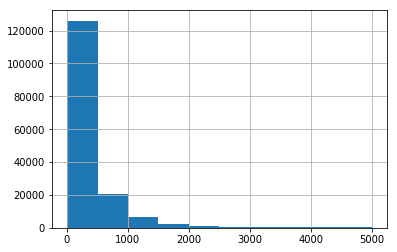

In [91]:
def dataExploration(trainData):   
    # look at the top five rows of the train data file
    # training data contains a row per comment, with an id, 
    # the text of the comment, and 6 different labels
    trainData.head()
    
    # exampel of a comment in the train data
    print (trainData['comment_text'][0])
    print ("")
    
    # the length of the comments varies a lot   
    lens = trainData.comment_text.str.len()
    print("Average length of comments: %d\nStandard dev: %d\nLongest Comment: %d" % (lens.mean(), lens.std(), lens.max()))
    
    print ("")
    print ("# Comments in train data: %d \n# Comments in test data: %d" % (len(train),len(test)))
    lens.hist()
    
dataExploration(train)
train.head()

## Preprocessing Data

In [108]:
def preProcessData(trainData, testData):
    # create a list of all the labels to predict
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    # create a 'none' label so we can see how many comments have no labels
    train['none'] = 1-train[label_cols].max(axis=1)
    
    train.describe()
    
    # get rid of the empty comments, otherwise sklearn complains
    COMMENT = 'comment_text'
    train[COMMENT].fillna("unknown", inplace=True)
    test[COMMENT].fillna("unknown", inplace=True)
    return label_cols

label_cols = preProcessData(train, test)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Extraction

In [107]:
def tokenize(s): 
    re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
    return re_tok.sub(r' \1 ', s).split()

# create bag of words representation, as a term document matrix using ngrams
def wordRepresentation(trainData, testData):
    # TF-IDF gives even better priors than the binarized features. 
    # it improves leaderboard score from 0.59 to 0.55.
    vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                   min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                   smooth_idf=1, sublinear_tf=1 )

    # Extracting features from the training data using a sparse vectorizer"
    train_term_doc = vec.fit_transform(trainData[COMMENT])

    # Extracting features from the test data using the same vectorizer
    test_term_doc = vec.transform(testData[COMMENT])

    # a sparse matrix with only a small number of non-zero elements with the below shape
    print("n_comments_train: %d, n_features: %d" % train_term_doc.shape)
    print("n_comments_test: %d, n_features: %d" % test_term_doc.shape)
    
    return train_term_doc, test_term_doc, vec
    
train_term_doc, test_term_doc, vec = wordRepresentation(train, test)

n_comments_train: 159571, n_features: 425477
n_comments_test: 153164, n_features: 425477


## Basic Naive Bayes Model

In [26]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [109]:
x = train_term_doc
test_x = test_term_doc

In [110]:
# Fit a model for one dependent at a time
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [129]:
# fit model and make predictions
def getPredictions(test, label_cols):
    
    model_r_dict = {}
    
    preds = np.zeros((len(test), len(label_cols)))

    for i, j in enumerate(label_cols):
        print('fitting', j)
        m,r = get_mdl(train[j])
        
        # store model and r value for future predictions
        model_r_dict[i] = r, m 
        
        # get predictions
        preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

    return preds, model_r_dict
    
preds, model_r_dict = getPredictions(test, label_cols)


fitting toxic
fitting severe_toxic
fitting obscene
fitting threat
fitting insult
fitting identity_hate


## Save Results to a file

In [121]:
# create the submission file and store the results
def saveResults(predictions):
    submission = pd.DataFrame.from_dict({'id': test['id']})
    for idx, col in enumerate(label_cols):
        submission[col] = predictions[:,idx]
    submission.to_csv('submission.csv', index=False)
    
saveResults(preds)

## Demo

In [136]:
# for demo purposes only
def demo(vectorizer, label_cols, model_r_dict):
    testing_comment = input("Enter a comment: ")

    # testing_comment = ["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time."]

    # vectorizer.transform takes list input so pass a list
    user_comment = []
    user_comment.append(testing_comment)
    
    # Extracting features from the test data using the vectorizer
    test_data_x = vectorizer.transform(user_comment)
    
    # to store the predictions
    prediction = np.zeros((1, len(label_cols)))

    # make prediction using the model created
    for i, j in enumerate(label_cols):
        r = model_r_dict[i][0]
        m = model_r_dict[i][1]
        prediction[0,i] = m.predict_proba(test_data_x.multiply(r))[0,1]
    
    # copy the result and display
    pred_y = pd.DataFrame(columns=label_cols)
    for idx, col in enumerate(label_cols):
        pred_y.at[0, col] = prediction[0,idx]  
     
    print ("")
    print (pred_y)
#     # The String I used above is for the first comment, that is, result of loc 0 in submission file
#     print ("This is the actual result: ", submission.loc[0])
    
demo(vec, label_cols, model_r_dict)      

Enter a comment: Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.

      toxic severe_toxic   obscene      threat    insult identity_hate
0  0.999988     0.105178  0.999987  0.00241179  0.963435     0.0970542
